In [ ]:
# !pip install transformers --upgrade
# !pip install torch

In [ ]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()  

use_gpu = torch.cuda.is_available()
if use_gpu:
    print("Using CUDA")

from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import os # accessing directory structure
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from google.colab import drive
drive.mount('/content/drive')

Using CUDA
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data restructure - large dataset for BERT, using only physicians lablels

In [ ]:
full_csv = "/content/drive/MyDrive/NNDL/PADCHEST_chest_x_ray_images_labels_160K_01.02.19.csv"

df1 = pd.read_csv(full_csv, delimiter=',')
df1.dataframeName = 'PADCHEST_chest_x_ray_images_labels_160K_01.02.19.csv'
nRow, nCol = df1.shape
print(f'There are {nRow} rows and {nCol} columns')

There are 160861 rows and 36 columns


/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (19,20) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
df1.head(3)

,Unnamed: 0,ImageID,ImageDir,StudyDate_DICOM,StudyID,PatientID,PatientBirth,PatientSex_DICOM,ViewPosition_DICOM,Projection,...,ExposureTime,RelativeXRayExposure_DICOM,ReportID,Report,MethodLabel,Labels,Localizations,LabelsLocalizationsBySentence,labelCUIS,LocalizationsCUIS
0,0,20536686640136348236148679891455886468_k6ga29.png,0,20140915,20536686640136348236148679891455886468,839860488694292331637988235681460987,1930.0,F,POSTEROANTERIOR,PA,...,10,-1.42,4765777,sin hallazg patolog edad pacient .,Physician,['normal'],[],"[['normal'], ['normal']]",[],[]
1,1,135803415504923515076821959678074435083_fzis7d...,0,20150914,135803415504923515076821959678074435083,313572750430997347502932654319389875966,1929.0,M,LATERAL,L,...,25,None,4991845,cambi pulmonar cronic sever . sign fibrosis b...,Physician,"['pulmonary fibrosis', 'chronic changes', 'kyp...","['loc basal', 'loc basal bilateral']","[['pulmonary fibrosis', 'loc basal bilateral']...",['C0034069' 'C0742362' 'C2115817' 'C3544344'],['C1282378']
2,2,135803415504923515076821959678074435083_fzis7b...,0,20150914,135803415504923515076821959678074435083,313572750430997347502932654319389875966,1929.0,M,POSTEROANTERIOR,PA,...,10,None,4991845,cambi pulmonar cronic sever . sign fibrosis b...,Physician,"['pulmonary fibrosis', 'chronic changes', 'kyp...","['loc basal', 'loc basal bilateral']","[['pulmonary fibrosis', 'loc basal bilateral']...",['C0034069' 'C0742362' 'C2115817' 'C3544344'],['C1282378']


In [ ]:
# Filter Physician labeled, we are only working with this portion of the dataset
df = df1[df1["MethodLabel"] == "Physician"]

df2 = df
df2.drop(columns=df2.columns[0], axis=1, inplace=True)
#print(df2)
# df = df1
df = df2
df.head(5)



/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,ImageID,ImageDir,StudyDate_DICOM,StudyID,PatientID,PatientBirth,PatientSex_DICOM,ViewPosition_DICOM,Projection,MethodProjection,...,ExposureTime,RelativeXRayExposure_DICOM,ReportID,Report,MethodLabel,Labels,Localizations,LabelsLocalizationsBySentence,labelCUIS,LocalizationsCUIS
0,20536686640136348236148679891455886468_k6ga29.png,0,20140915,20536686640136348236148679891455886468,839860488694292331637988235681460987,1930.0,F,POSTEROANTERIOR,PA,Manual review of DICOM fields,...,10,-1.42,4765777,sin hallazg patolog edad pacient .,Physician,['normal'],[],"[['normal'], ['normal']]",[],[]
1,135803415504923515076821959678074435083_fzis7d...,0,20150914,135803415504923515076821959678074435083,313572750430997347502932654319389875966,1929.0,M,LATERAL,L,Manual review of DICOM fields,...,25,None,4991845,cambi pulmonar cronic sever . sign fibrosis b...,Physician,"['pulmonary fibrosis', 'chronic changes', 'kyp...","['loc basal', 'loc basal bilateral']","[['pulmonary fibrosis', 'loc basal bilateral']...",['C0034069' 'C0742362' 'C2115817' 'C3544344'],['C1282378']
2,135803415504923515076821959678074435083_fzis7b...,0,20150914,135803415504923515076821959678074435083,313572750430997347502932654319389875966,1929.0,M,POSTEROANTERIOR,PA,Manual review of DICOM fields,...,10,None,4991845,cambi pulmonar cronic sever . sign fibrosis b...,Physician,"['pulmonary fibrosis', 'chronic changes', 'kyp...","['loc basal', 'loc basal bilateral']","[['pulmonary fibrosis', 'loc basal bilateral']...",['C0034069' 'C0742362' 'C2115817' 'C3544344'],['C1282378']
3,113855343774216031107737439268243531979_3k951l...,0,20150717,113855343774216031107737439268243531979,50783093527901818115346441867348318648,1925.0,F,POSTEROANTERIOR,PA,Manual review of DICOM fields,...,8,None,4955977,. . siluet cardi mediastin dentr normal . cam...,Physician,['chronic changes'],"['loc cardiac', 'loc mediastinum', 'loc costop...","[['chronic changes'], ['chronic changes'], ['n...",['C0742362'],['C1522601' 'C0025066' 'C0230151']
4,113855343774216031107737439268243531979_3k951n...,0,20150717,113855343774216031107737439268243531979,50783093527901818115346441867348318648,1925.0,F,LATERAL,L,Manual review of DICOM fields,...,20,None,4955977,. . siluet cardi mediastin dentr normal . cam...,Physician,['chronic changes'],"['loc cardiac', 'loc mediastinum', 'loc costop...","[['chronic changes'], ['chronic changes'], ['n...",['C0742362'],['C1522601' 'C0025066' 'C0230151']


In [ ]:
#create field with labels flattened to a single sequence
import ast
def delabel(labels):
    r = None
    if labels is not None:
        try:
            r = pd.Series([label.strip() for label in  ast.literal_eval(labels)]).dropna().values
        except:
            r = None
    return r
    
df.loc[:,'labels'] = df1.loc[:,'Labels'].apply(lambda l: delabel(l))

# Re label dataset into normal and not normal
normal = df[df.labels.map(lambda x: 'normal'  in x and x.shape[0] == 1)]
df_final = df[['ImageID','labels', 'Report']]
df_final.loc[:,'Normal'] = False
df_final.loc[df.labels.map(lambda x: 'normal'  in x and x.shape[0] == 1),'Normal' ] = True

df_final.head(5)

/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


,ImageID,labels,Report,Normal
0,20536686640136348236148679891455886468_k6ga29.png,[normal],sin hallazg patolog edad pacient .,True
1,135803415504923515076821959678074435083_fzis7d...,"[pulmonary fibrosis, chronic changes, kyphosis...",cambi pulmonar cronic sever . sign fibrosis b...,False
2,135803415504923515076821959678074435083_fzis7b...,"[pulmonary fibrosis, chronic changes, kyphosis...",cambi pulmonar cronic sever . sign fibrosis b...,False
3,113855343774216031107737439268243531979_3k951l...,[chronic changes],. . siluet cardi mediastin dentr normal . cam...,False
4,113855343774216031107737439268243531979_3k951n...,[chronic changes],. . siluet cardi mediastin dentr normal . cam...,False


In [ ]:
df_final.drop(index=df_final.index[0], axis=0, inplace=True)

/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [ ]:
df_final.head()

,ImageID,labels,Report,Normal
1,135803415504923515076821959678074435083_fzis7d...,"[pulmonary fibrosis, chronic changes, kyphosis...",cambi pulmonar cronic sever . sign fibrosis b...,False
2,135803415504923515076821959678074435083_fzis7b...,"[pulmonary fibrosis, chronic changes, kyphosis...",cambi pulmonar cronic sever . sign fibrosis b...,False
3,113855343774216031107737439268243531979_3k951l...,[chronic changes],. . siluet cardi mediastin dentr normal . cam...,False
4,113855343774216031107737439268243531979_3k951n...,[chronic changes],. . siluet cardi mediastin dentr normal . cam...,False
5,313903302629300007485735352869488750471_75sg0k...,"[unchanged, alveolar pattern, interstitial pat...",objet mejori radiolog con practic resolucion ...,False


In [ ]:
df_final.Normal.value_counts() 

False    26359
True     12693
Name: Normal, dtype: int64

In [ ]:
#rename the dataframe containing the total dataset
df_full_report_only = df_final

## Images dataset - this is for the small kaggle dataset

In [ ]:
images_df = pd.DataFrame()

images_list = []

for dirname, _, filenames in os.walk('/content/drive/MyDrive/NNDL/data_sample_kaggle/sample'):
    for filename in filenames:
      #print(os.path.join(dirname, filename))
      #get the label
      # temp_df = pd.DataFrame([filename], columns = ["ImageID"])
      # images_df = df.append(temp_df, ignore_index=True)
      images_list.append(filename)

images_df["ImageID"] = images_list

images_df.head(10)
print(len(images_df))

24


In [ ]:
# merge datasets
df_merged = images_df.merge(df_final, left_on = "ImageID", right_on = "ImageID")
df_merged.head(10)

,ImageID,labels,Report,Normal
0,101103270798497222826083823719046670601_jw1fu2...,"[alveolar pattern, cardiomegaly, vascular hila...",. . . . cardiomegali . pinzamient ambos sen c...,False
1,216840111366964012373310883942009084123158919_...,"[infiltrates, pneumonia]",infiltr subsegmentari nivel lm perifer con ca...,False
2,216840111366964012558082906712010004133151165_...,"[laminar atelectasis, supra aortic elongation,...",mejori radiolog con resolucion infiltr bilate...,False
3,126397712012687540784611673197697059691_fp0cu9...,[unchanged],sin hallazg radiolog signific . sin cambi con...,False
4,216840111366964012819207061112010316094555679_...,[normal],estudi dentr limit normal .,True
5,216840111366964012373310883942009181081546904_...,"[aortic elongation, COPD signs]",elongacion aortic . sign radiolog epoc .,False
6,216840111366964012948363412702011013123142008_...,[normal],sin hallazg patolog relev .,True
7,216840111366964013076187734852011291090122566_...,"[cardiomegaly, interstitial pattern, unchanged]",cardiomegali . sign edem intersticial con pat...,False
8,216840111366964013293097335992012048173805692_...,[normal],sin hallazg signific patolog .,True
9,216840111366964013217898866992011329134906098_...,"[nodule, interstitial pattern, pulmonary fibro...",nodul proyect lsd 1 4 cm contorn parcial bien...,False


In [ ]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df_merged, test_size = 0.2)

print("Train size:", len(train))
print("Test size:", len(test))

Train size: 19
Test size: 5


## Images dataset - this is for the 10GB Padchest dataset

In [ ]:
images_df = pd.DataFrame()

images_list = []

for dirname, _, filenames in os.walk('/content/drive/MyDrive/NNDL/data_sample_kaggle/sample'):
    for filename in filenames:
      #print(os.path.join(dirname, filename))
      #get the label
      # temp_df = pd.DataFrame([filename], columns = ["ImageID"])
      # images_df = df.append(temp_df, ignore_index=True)
      images_list.append(filename)

images_df["ImageID"] = images_list

images_df.head(10)
print(len(images_df))

24


In [ ]:
# merge datasets
df_merged = images_df.merge(df_final, left_on = "ImageID", right_on = "ImageID")
df_merged.head(10)

,ImageID,labels,Report,Normal
0,101103270798497222826083823719046670601_jw1fu2...,"[alveolar pattern, cardiomegaly, vascular hila...",. . . . cardiomegali . pinzamient ambos sen c...,False
1,216840111366964012373310883942009084123158919_...,"[infiltrates, pneumonia]",infiltr subsegmentari nivel lm perifer con ca...,False
2,216840111366964012558082906712010004133151165_...,"[laminar atelectasis, supra aortic elongation,...",mejori radiolog con resolucion infiltr bilate...,False
3,126397712012687540784611673197697059691_fp0cu9...,[unchanged],sin hallazg radiolog signific . sin cambi con...,False
4,216840111366964012819207061112010316094555679_...,[normal],estudi dentr limit normal .,True
5,216840111366964012373310883942009181081546904_...,"[aortic elongation, COPD signs]",elongacion aortic . sign radiolog epoc .,False
6,216840111366964012948363412702011013123142008_...,[normal],sin hallazg patolog relev .,True
7,216840111366964013076187734852011291090122566_...,"[cardiomegaly, interstitial pattern, unchanged]",cardiomegali . sign edem intersticial con pat...,False
8,216840111366964013293097335992012048173805692_...,[normal],sin hallazg signific patolog .,True
9,216840111366964013217898866992011329134906098_...,"[nodule, interstitial pattern, pulmonary fibro...",nodul proyect lsd 1 4 cm contorn parcial bien...,False


# Data restructure - small kaggle (test) dataset, all

In [ ]:
for dirname, _, filenames in os.walk('/content/drive/MyDrive/NNDL/data_sample_kaggle/sample'):
    for filename in filenames:
      print(os.path.join(dirname, filename))

/content/drive/MyDrive/NNDL/data_sample_kaggle/sample/216840111366964012558082906712010004133151165_00-119-134.png
/content/drive/MyDrive/NNDL/data_sample_kaggle/sample/216840111366964013395900950222012171101555757_01-139-142.png
/content/drive/MyDrive/NNDL/data_sample_kaggle/sample/317759408657031098460852906419716899073_2rq56f.png
/content/drive/MyDrive/NNDL/data_sample_kaggle/sample/216840111366964013451228379692012269104148390_01-054-004.png
/content/drive/MyDrive/NNDL/data_sample_kaggle/sample/216840111366964013293097335992012048173805692_01-094-011.png
/content/drive/MyDrive/NNDL/data_sample_kaggle/sample/216840111366964013217898866992011329134906098_01-027-105.png
/content/drive/MyDrive/NNDL/data_sample_kaggle/sample/126397712012687540784611673197697059691_fp0cu9.png
/content/drive/MyDrive/NNDL/data_sample_kaggle/sample/216840111366964013451228379692012257110540618_02-006-005.png
/content/drive/MyDrive/NNDL/data_sample_kaggle/sample/216840111366964012819207061112010316094555679_

In [ ]:
test_dataframe = pd.read_csv('/content/drive/MyDrive/NNDL/data_sample_kaggle/chest_x_ray_images_labels_sample.csv', delimiter=',')
test_dataframe.dataframeName = 'chest_x_ray_images_labels_sample.csv'
nRow, nCol = test_dataframe.shape
print(f'There are {nRow} rows and {nCol} columns')

There are 24 rows and 35 columns


In [ ]:
test_dataframe.head(3)

,ImageID,ImageDir,StudyDate_DICOM,StudyID,PatientID,PatientBirth,PatientSex_DICOM,ViewPosition_DICOM,Projection,MethodProjection,...,ExposureTime,RelativeXRayExposure_DICOM,ReportID,Report,MethodLabel,Labels,Localizations,LabelsLocalizationsBySentence,labelCUIS,LocalizationsCUIS
0,216840111366964012819207061112010316094555679_...,53.0,20101115,216840111366964012819207061112010316094555679,165520659828517651319895455219077146076,1977.0,M,POSTEROANTERIOR,PA,Manual review of DICOM fields,...,10,-2.4,3940268,estudi dentr limit normal .,RNN_model,['normal'],[],['normal'],[],[]
1,216840111366964012373310883942009181081546904_...,45.0,20090701,216840111366964012373310883942009181081546904,72174654964358752240615468557485388320,1948.0,M,POSTEROANTERIOR,PA,Manual review of DICOM fields,...,10,-2.11,3651544,elongacion aortic . sign radiolog epoc .,RNN_model,"['aortic elongation', 'COPD signs']",['loc aortic'],"['aortic elongation', 'loc aortic', 'COPD signs']",['C0024117'],['C0003483']
2,126397712012687540784611673197697059691_fp0cu9...,1.0,20150129,126397712012687540784611673197697059691,319252773629655032802201564086419801728,2005.0,F,NaN,L,Manual review of DICOM fields,...,0,412,4851331,sin hallazg radiolog signific . sin cambi con...,Physician,['unchanged'],[],"[['normal'], ['unchanged']]",[],[]


In [ ]:
# Filter Physician labeled, we are only working with this portion of the dataset
#df = df1[df1["MethodLabel"] == "Physician"]
df = df1
df.head(5)

,ImageID,ImageDir,StudyDate_DICOM,StudyID,PatientID,PatientBirth,PatientSex_DICOM,ViewPosition_DICOM,Projection,MethodProjection,...,ExposureTime,RelativeXRayExposure_DICOM,ReportID,Report,MethodLabel,Labels,Localizations,LabelsLocalizationsBySentence,labelCUIS,LocalizationsCUIS
0,216840111366964012819207061112010316094555679_...,53.0,20101115,216840111366964012819207061112010316094555679,165520659828517651319895455219077146076,1977.0,M,POSTEROANTERIOR,PA,Manual review of DICOM fields,...,10,-2.4,3940268,estudi dentr limit normal .,RNN_model,['normal'],[],['normal'],[],[]
1,216840111366964012373310883942009181081546904_...,45.0,20090701,216840111366964012373310883942009181081546904,72174654964358752240615468557485388320,1948.0,M,POSTEROANTERIOR,PA,Manual review of DICOM fields,...,10,-2.11,3651544,elongacion aortic . sign radiolog epoc .,RNN_model,"['aortic elongation', 'COPD signs']",['loc aortic'],"['aortic elongation', 'loc aortic', 'COPD signs']",['C0024117'],['C0003483']
2,126397712012687540784611673197697059691_fp0cu9...,1.0,20150129,126397712012687540784611673197697059691,319252773629655032802201564086419801728,2005.0,F,NaN,L,Manual review of DICOM fields,...,0,412,4851331,sin hallazg radiolog signific . sin cambi con...,Physician,['unchanged'],[],"[['normal'], ['unchanged']]",[],[]
3,216840111366964013307756408102012093111819763_...,28.0,20120412,216840111366964013307756408102012093111819763,57401592284601066707918155169506868963,1973.0,M,POSTEROANTERIOR,PA,Manual review of DICOM fields,...,10,-1.42,4238489,pinzamient sen costofren derech .,RNN_model,['costophrenic angle blunting'],"['loc costophrenic angle', 'loc right costophr...","['costophrenic angle blunting', 'loc costophre...",['C0742855'],['C0230151' 'C0504099']
4,216840111366964012558082906712010004133151165_...,47.0,20100104,216840111366964012558082906712010004133151165,274064412965433183908763443227787634177,1929.0,M,LATERAL,L,Manual review of DICOM fields,...,25,-0.35,3755181,mejori radiolog con resolucion infiltr bilate...,RNN_model,"['laminar atelectasis', 'supra aortic elongati...","['loc supra aortic', 'loc left', 'loc cardiac'...","['normal', 'loc bilateral', 'laminar atelectas...",['C0018800'],['C0443246' 'C1522601' 'C1282378' 'C0003483' '...


In [ ]:
#test dataframe

import ast
def delabel(labels):
    r = None
    if labels is not None:
        try:
            r = pd.Series([label.strip() for label in  ast.literal_eval(labels)]).dropna().values
        except:
            r = None
    return r
    
test_dataframe.loc[:,'labels'] = test_dataframe.loc[:,'Labels'].apply(lambda l: delabel(l))

# Re label dataset into normal and not normal
normal = test_dataframe[test_dataframe.labels.map(lambda x: 'normal'  in x and x.shape[0] == 1)]
df_final_test = test_dataframe[['ImageID','labels', 'Report']]
df_final_test.loc[:,'Normal'] = False
df_final_test.loc[test_dataframe.labels.map(lambda x: 'normal'  in x and x.shape[0] == 1),'Normal' ] = True
df_final_test.head(5)

/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


,ImageID,labels,Report,Normal
0,216840111366964012819207061112010316094555679_...,[normal],estudi dentr limit normal .,True
1,216840111366964012373310883942009181081546904_...,"[aortic elongation, COPD signs]",elongacion aortic . sign radiolog epoc .,False
2,126397712012687540784611673197697059691_fp0cu9...,[unchanged],sin hallazg radiolog signific . sin cambi con...,False
3,216840111366964013307756408102012093111819763_...,[costophrenic angle blunting],pinzamient sen costofren derech .,False
4,216840111366964012558082906712010004133151165_...,"[laminar atelectasis, supra aortic elongation,...",mejori radiolog con resolucion infiltr bilate...,False


In [ ]:
#create field with labels flattened to a single sequence
import ast
def delabel(labels):
    r = None
    if labels is not None:
        try:
            r = pd.Series([label.strip() for label in  ast.literal_eval(labels)]).dropna().values
        except:
            r = None
    return r
    
df.loc[:,'labels'] = df1.loc[:,'Labels'].apply(lambda l: delabel(l))

# Re label dataset into normal and not normal
normal = df[df.labels.map(lambda x: 'normal'  in x and x.shape[0] == 1)]
df_final = df[['ImageID','labels', 'Report']]
df_final.loc[:,'Normal'] = False
df_final.loc[df.labels.map(lambda x: 'normal'  in x and x.shape[0] == 1),'Normal' ] = True
df_final.head(5)

/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


,ImageID,labels,Report,Normal
0,216840111366964012819207061112010316094555679_...,[normal],estudi dentr limit normal .,True
1,216840111366964012373310883942009181081546904_...,"[aortic elongation, COPD signs]",elongacion aortic . sign radiolog epoc .,False
2,126397712012687540784611673197697059691_fp0cu9...,[unchanged],sin hallazg radiolog signific . sin cambi con...,False
3,216840111366964013307756408102012093111819763_...,[costophrenic angle blunting],pinzamient sen costofren derech .,False
4,216840111366964012558082906712010004133151165_...,"[laminar atelectasis, supra aortic elongation,...",mejori radiolog con resolucion infiltr bilate...,False


In [ ]:
df_final.Normal.value_counts() 

False    15
True      9
Name: Normal, dtype: int64

### Images dataset

In [ ]:
images_df = pd.DataFrame()

images_list = []

for dirname, _, filenames in os.walk('/content/drive/MyDrive/NNDL/data_sample_kaggle/sample'):
    for filename in filenames:
      #print(os.path.join(dirname, filename))
      #get the label
      # temp_df = pd.DataFrame([filename], columns = ["ImageID"])
      # images_df = df.append(temp_df, ignore_index=True)
      images_list.append(filename)

images_df["ImageID"] = images_list

images_df.head(10)
print(len(images_df))

24


In [ ]:
# merge datasets
df_merged = images_df.merge(df_final, left_on = "ImageID", right_on = "ImageID")
df_merged.head(10)

,ImageID,labels,Report,Normal
0,101103270798497222826083823719046670601_jw1fu2...,"[alveolar pattern, cardiomegaly, vascular hila...",. . . . cardiomegali . pinzamient ambos sen c...,False
1,216840111366964012373310883942009084123158919_...,"[infiltrates, pneumonia]",infiltr subsegmentari nivel lm perifer con ca...,False
2,216840111366964012558082906712010004133151165_...,"[laminar atelectasis, supra aortic elongation,...",mejori radiolog con resolucion infiltr bilate...,False
3,126397712012687540784611673197697059691_fp0cu9...,[unchanged],sin hallazg radiolog signific . sin cambi con...,False
4,216840111366964012819207061112010316094555679_...,[normal],estudi dentr limit normal .,True
5,216840111366964012373310883942009181081546904_...,"[aortic elongation, COPD signs]",elongacion aortic . sign radiolog epoc .,False
6,216840111366964012948363412702011013123142008_...,[normal],sin hallazg patolog relev .,True
7,216840111366964013076187734852011291090122566_...,"[cardiomegaly, interstitial pattern, unchanged]",cardiomegali . sign edem intersticial con pat...,False
8,216840111366964013293097335992012048173805692_...,[normal],sin hallazg signific patolog .,True
9,216840111366964013217898866992011329134906098_...,"[nodule, interstitial pattern, pulmonary fibro...",nodul proyect lsd 1 4 cm contorn parcial bien...,False


In [ ]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df_merged, test_size = 0.2)

print("Train size:", len(train))
print("Test size:", len(test))

Train size: 19
Test size: 5


# Restructure data and create ImageFolder - small kaggle dataset (test)

In order to perform and finetuning over InceptionV3 to retrain the model for this dataset, we need to restructure the folders to follow the ImageFolder structure.

Final structure:
```
padchest_sample2_model 
   |
   ---- train
          |
          ---- normal
          --- not_normal
   ---- val
          |
          ---- normal
          --- not_normal
```






In [ ]:
import torch
model = torch.hub.load('pytorch/vision:v0.10.0', 'inception_v3', pretrained=True)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
df_merged.head(3)

,ImageID,labels,Report,Normal
0,317759408657031098460852906419716899073_2rq56f...,"[kyphosis, vertebral degenerative changes, rib...",parenquim pulmon siluet cardiomediastin dentr...,False
1,216840111366964013395900950222012171101555757_...,[normal],sin alter radiolog significacion .,True
2,216840111366964014008416513202014153161516671_...,[normal],sin hallazg signific .,True


In [ ]:
df_merged.Normal.value_counts()

False    15
True      9
Name: Normal, dtype: int64

In [ ]:
img_filenames = list()
img_ids = list()
for dirname, _, filenames in os.walk(
    '/content/drive/MyDrive/NNDL/data_sample_kaggle/sample'):
    for filename in filenames:
      if filename in list(df_merged.ImageID):
        img_filenames.append(os.path.join(dirname, filename))
        img_ids.append(filename)
img_filenames, img_ids

(['/content/drive/MyDrive/NNDL/data_sample_kaggle/sample/317759408657031098460852906419716899073_2rq56f.png',
  '/content/drive/MyDrive/NNDL/data_sample_kaggle/sample/216840111366964013395900950222012171101555757_01-139-142.png',
  '/content/drive/MyDrive/NNDL/data_sample_kaggle/sample/216840111366964014008416513202014153161516671_01-196-149.png',
  '/content/drive/MyDrive/NNDL/data_sample_kaggle/sample/216840111366964013340662495472012111130929144_01-108-133.png',
  '/content/drive/MyDrive/NNDL/data_sample_kaggle/sample/126397712012687540784611673197697059691_fp0cu9.png',
  '/content/drive/MyDrive/NNDL/data_sample_kaggle/sample/216840111366964013076187734852011291090122566_00-195-189.png',
  '/content/drive/MyDrive/NNDL/data_sample_kaggle/sample/216840111366964013293097335992012048173805692_01-094-011.png',
  '/content/drive/MyDrive/NNDL/data_sample_kaggle/sample/216840111366964013217898866992011349123010433_01-006-043.png',
  '/content/drive/MyDrive/NNDL/data_sample_kaggle/sample/216

In [ ]:
#df_final_test

import os
import shutil
import re

full_dataset = "/content/drive/MyDrive/NNDL/data_sample_kaggle/sample"

# data_to_go = "/content/drive/MyDrive/NNDL/padchest_sample2_model/train"

data_to_go = "/content/drive/MyDrive/NNDL/data_sample_kaggle/sample/test"

try:
  os.mkdir(data_to_go)
  os.mkdir(data_to_go + "/normal")
  os.mkdir(data_to_go + "/not_normal")
except OSError:
  print("error")

for dirname, _, filenames in os.walk(full_dataset):
  for id in filenames:
    row = df_final_test.loc[df_final_test['ImageID'] == id]
    if row.Normal.values:
      shutil.copy(f'{full_dataset}/{id}', f"{data_to_go}/normal")
    else:
      shutil.copy(f'{full_dataset}/{id}', f"{data_to_go}/not_normal")

In [ ]:
import os
import shutil
import re

full_dataset = "/content/drive/MyDrive/NNDL/data_sample_kaggle/sample"

data_to_go = "/content/drive/MyDrive/NNDL/padchest_sample2_model/train"

try:
  os.mkdir(data_to_go)
  os.mkdir(data_to_go + "/normal")
  os.mkdir(data_to_go + "/not_normal")
except OSError:
  print("error")

for dirname, _, filenames in os.walk(full_dataset):
  for id in filenames:
    row = df_merged.loc[df_merged['ImageID'] == id]
    if row.Normal.values:
      shutil.copy(f'{full_dataset}/{id}', f"{data_to_go}/normal")
    else:
      shutil.copy(f'{full_dataset}/{id}', f"{data_to_go}/not_normal")

In [ ]:
# Make the validation directories
try:
    os.makedirs("/content/drive/MyDrive/NNDL/padchest_sample2_model/val/normal")
    os.makedirs("/content/drive/MyDrive/NNDL/padchest_sample2_model/val/not_normal")
except OSError:
    print ("Creation of the directory %s failed")
else:
    print ("Successfully created the directory %s ")

Successfully created the directory %s 


In [ ]:
import math

#move 20% of images to the vaidation folder
total_train_normal = "/content/drive/MyDrive/NNDL/padchest_sample2_model/train/normal"
total_train_not_normal = "/content/drive/MyDrive/NNDL/padchest_sample2_model/train/not_normal"

validation = "/content/drive/MyDrive/NNDL/padchest_sample2_model/val"
try:
  os.mkdir(data_to_go + "/normal")
  os.mkdir(data_to_go + "/not_normal")
except OSError:
  print("")

#move 20% of each

#normal
i = 0
for dirname, _, filenames in os.walk(total_train_normal):
  p = math.floor(0.2 * (len(filenames)))
  for id in filenames:
    row = df_merged.loc[df_merged['ImageID'] == id]
    shutil.move(f'{total_train_normal}/{id}', f"{validation}/normal")
    i += 1
    if (i > p):
      break

#not_normal
i = 0
for dirname, _, filenames in os.walk(total_train_not_normal):
  p = math.floor(0.2 * (len(filenames)))
  for id in filenames:
    row = df_merged.loc[df_merged['ImageID'] == id]
    shutil.move(f'{total_train_not_normal}/{id}', f"{validation}/not_normal")
    i += 1
    if (i > p):
      break


In [ ]:
#citations:  
#https://www.researchgate.net/figure/nceptionV3-architecture-designed-for-binary-classification_fig2_353494880 binary classification inceptionv3
# https://stackabuse.com/image-classification-with-transfer-learning-and-pytorch/

# Restructure data and create ImageFolder (chex dataset) (training)

In order to perform and finetuning over InceptionV3 to retrain the model for this dataset, we need to restructure the folders to follow the ImageFolder structure.

Final structure:
```
padchest_sample2_model 
   |
   ---- train
          |
          ---- normal
          --- not_normal
   ---- val
          |
          ---- normal
          --- not_normal
```






In [ ]:
import torch
model = torch.hub.load('pytorch/vision:v0.10.0', 'inception_v3', pretrained=True)

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth


  0%|          | 0.00/104M [00:00<?, ?B/s]

In [ ]:
train_df = pd.read_csv('/content/drive/MyDrive/NNDL/chexsmall/CheXpert-v1.0-small/train.csv', delimiter=',')
train_df.dataframeName = 'train.csv'
nRow, nCol = train_df.shape
print(f'There are {nRow} rows and {nCol} columns')

There are 223414 rows and 19 columns


In [ ]:
train_df.head(3)

,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices
0,CheXpert-v1.0-small/train/patient00001/study1/...,Female,68,Frontal,AP,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,1.0
1,CheXpert-v1.0-small/train/patient00002/study2/...,Female,87,Frontal,AP,NaN,NaN,-1.0,1.0,NaN,-1.0,-1.0,NaN,-1.0,NaN,-1.0,NaN,1.0,NaN
2,CheXpert-v1.0-small/train/patient00002/study1/...,Female,83,Frontal,AP,NaN,NaN,NaN,1.0,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN


In [ ]:
temp_train_df = train_df[train_df["No Finding"] == 1.0]
temp_train_df.head()

,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices
0,CheXpert-v1.0-small/train/patient00001/study1/...,Female,68,Frontal,AP,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,1.0
5,CheXpert-v1.0-small/train/patient00004/study1/...,Female,20,Frontal,PA,1.0,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN
6,CheXpert-v1.0-small/train/patient00004/study1/...,Female,20,Lateral,NaN,1.0,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN
7,CheXpert-v1.0-small/train/patient00005/study1/...,Male,33,Frontal,PA,1.0,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,1.0
8,CheXpert-v1.0-small/train/patient00005/study1/...,Male,33,Lateral,NaN,1.0,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,1.0


In [ ]:
temp_train_df.Sex.value_counts() 

Male       13111
Female      9269
Unknown        1
Name: Sex, dtype: int64

In [ ]:
df1 = train_df
df1.columns = [c.replace(' ', '_') for c in df1.columns]

In [ ]:
df1.head()

,Path,Sex,Age,Frontal/Lateral,AP/PA,No_Finding,Enlarged_Cardiomediastinum,Cardiomegaly,Lung_Opacity,Lung_Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural_Effusion,Pleural_Other,Fracture,Support_Devices
0,CheXpert-v1.0-small/train/patient00001/study1/...,Female,68,Frontal,AP,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,1.0
1,CheXpert-v1.0-small/train/patient00002/study2/...,Female,87,Frontal,AP,NaN,NaN,-1.0,1.0,NaN,-1.0,-1.0,NaN,-1.0,NaN,-1.0,NaN,1.0,NaN
2,CheXpert-v1.0-small/train/patient00002/study1/...,Female,83,Frontal,AP,NaN,NaN,NaN,1.0,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN
3,CheXpert-v1.0-small/train/patient00002/study1/...,Female,83,Lateral,NaN,NaN,NaN,NaN,1.0,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN
4,CheXpert-v1.0-small/train/patient00003/study1/...,Male,41,Frontal,AP,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN


In [ ]:
df1.No_Finding.value_counts() 

1.0    22381
Name: No_Finding, dtype: int64

In [ ]:
#citations:  
#https://www.researchgate.net/figure/nceptionV3-architecture-designed-for-binary-classification_fig2_353494880 binary classification inceptionv3
# https://stackabuse.com/image-classification-with-transfer-learning-and-pytorch/

# REDUCE data amount Restructure data and create ImageFolder (chex dataset) (training)

In order to perform and finetuning over InceptionV3 to retrain the model for this dataset, we need to restructure the folders to follow the ImageFolder structure.

Final structure:
```
padchest_sample2_model 
   |
   ---- train
          |
          ---- normal
          --- not_normal
   ---- val
          |
          ---- normal
          --- not_normal
```






In [ ]:
import torch
model = torch.hub.load('pytorch/vision:v0.10.0', 'inception_v3', pretrained=True)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


In [ ]:
train_df = pd.read_csv('/content/drive/MyDrive/NNDL/chexsmall/CheXpert-v1.0-small/train.csv', delimiter=',')
train_df.dataframeName = 'train.csv'
nRow, nCol = train_df.shape
print(f'There are {nRow} rows and {nCol} columns')

There are 223414 rows and 19 columns


In [ ]:
df_val = pd.read_csv('/content/drive/MyDrive/NNDL/chexsmall/CheXpert-v1.0-small/valid.csv', delimiter=',')
df_val.dataframeName = 'valid.csv'
nRow, nCol = df_val.shape
print(f'There are {nRow} rows and {nCol} columns')

There are 234 rows and 19 columns


In [ ]:
train_df.head(3)

,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices
0,CheXpert-v1.0-small/train/patient00001/study1/...,Female,68,Frontal,AP,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,1.0
1,CheXpert-v1.0-small/train/patient00002/study2/...,Female,87,Frontal,AP,NaN,NaN,-1.0,1.0,NaN,-1.0,-1.0,NaN,-1.0,NaN,-1.0,NaN,1.0,NaN
2,CheXpert-v1.0-small/train/patient00002/study1/...,Female,83,Frontal,AP,NaN,NaN,NaN,1.0,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN


In [ ]:


# temp_train_df = train_df[train_df["No Finding"] == 1.0]
# temp_train_df.head()

,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices
0,CheXpert-v1.0-small/train/patient00001/study1/...,Female,68,Frontal,AP,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,1.0
5,CheXpert-v1.0-small/train/patient00004/study1/...,Female,20,Frontal,PA,1.0,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN
6,CheXpert-v1.0-small/train/patient00004/study1/...,Female,20,Lateral,NaN,1.0,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN
7,CheXpert-v1.0-small/train/patient00005/study1/...,Male,33,Frontal,PA,1.0,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,1.0
8,CheXpert-v1.0-small/train/patient00005/study1/...,Male,33,Lateral,NaN,1.0,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,1.0


In [ ]:
temp_train_df.Sex.value_counts() 

Male       13111
Female      9269
Unknown        1
Name: Sex, dtype: int64

In [ ]:
df1 = train_df
df1.columns = [c.replace(' ', '_') for c in df1.columns]

In [ ]:
df_val.columns = [c.replace(' ', '_') for c in df_val.columns]

In [ ]:
df_val.head()

,Path,Sex,Age,Frontal/Lateral,AP/PA,No_Finding,Enlarged_Cardiomediastinum,Cardiomegaly,Lung_Opacity,Lung_Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural_Effusion,Pleural_Other,Fracture,Support_Devices
0,CheXpert-v1.0-small/valid/patient64541/study1/...,Male,73,Frontal,AP,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,CheXpert-v1.0-small/valid/patient64542/study1/...,Male,70,Frontal,PA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,CheXpert-v1.0-small/valid/patient64542/study1/...,Male,70,Lateral,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,CheXpert-v1.0-small/valid/patient64543/study1/...,Male,85,Frontal,AP,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,CheXpert-v1.0-small/valid/patient64544/study1/...,Female,42,Frontal,AP,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
df_val.head()

,Path,Sex,Age,Frontal/Lateral,AP/PA,No_Finding,Enlarged_Cardiomediastinum,Cardiomegaly,Lung_Opacity,Lung_Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural_Effusion,Pleural_Other,Fracture,Support_Devices
0,CheXpert-v1.0-small/valid/patient64541/study1/...,Male,73,Frontal,AP,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,CheXpert-v1.0-small/valid/patient64542/study1/...,Male,70,Frontal,PA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,CheXpert-v1.0-small/valid/patient64542/study1/...,Male,70,Lateral,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,CheXpert-v1.0-small/valid/patient64543/study1/...,Male,85,Frontal,AP,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,CheXpert-v1.0-small/valid/patient64544/study1/...,Female,42,Frontal,AP,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
df1.No_Finding.value_counts() 

df1

1.0    22381
Name: No_Finding, dtype: int64

In [ ]:
df_val.No_Finding.value_counts()

0.0    196
1.0     38
Name: No_Finding, dtype: int64

In [ ]:
df_val = df_val[['Path', 'No_Finding']]
df_val.loc[:,'Normal'] = False

df_val['No_Finding'] = df_val['No_Finding'].fillna(0)

df_final

df3 = df_val
df3.loc[:,'Normal'] = False

df_val = df3[['Path', 'No_Finding']]

df_val.rename(columns = {'No_Finding':'Normal'}, inplace = True)
df_val.rename(columns = {'Path':'ImageID'}, inplace = True)

df_val["Normal"] = df_val["Normal"].astype(int)

df_val.replace({0: False, 1: True}, inplace=True)

df_val.head(5)

/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
<ipython-input-35-c7ccc720e8d0>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_val['No_Finding'] = df_val['No_Finding'].fillna(0)
/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the

,ImageID,Normal
0,CheXpert-v1.0-small/valid/patient64541/study1/...,False
1,CheXpert-v1.0-small/valid/patient64542/study1/...,False
2,CheXpert-v1.0-small/valid/patient64542/study1/...,False
3,CheXpert-v1.0-small/valid/patient64543/study1/...,False
4,CheXpert-v1.0-small/valid/patient64544/study1/...,True


In [ ]:
df_final = df1[['Path', 'No_Finding']]
df_final.loc[:,'Normal'] = False

df_final['No_Finding'] = df_final['No_Finding'].fillna(0)

#df_final.loc[df1.No_Finding.map({1.0: True, 0.0: False})]
df3 = df_final
df3.loc[:,'Normal'] = False
# df3.loc[df_final.No_Finding.map({1.0: True, 0.0: False})] = True
#df3.head(5)

df_final = df3[['Path', 'No_Finding']]

df_final.rename(columns = {'No_Finding':'Normal'}, inplace = True)
df_final.rename(columns = {'Path':'ImageID'}, inplace = True)

df_final["Normal"] = df_final["Normal"].astype(int)

df_final.replace({0: False, 1: True}, inplace=True)

df_final.head(5)



/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
<ipython-input-6-7409c7722953>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['No_Finding'] = df_final['No_Finding'].fillna(0)
/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

,ImageID,Normal
0,CheXpert-v1.0-small/train/patient00001/study1/...,True
1,CheXpert-v1.0-small/train/patient00002/study2/...,False
2,CheXpert-v1.0-small/train/patient00002/study1/...,False
3,CheXpert-v1.0-small/train/patient00002/study1/...,False
4,CheXpert-v1.0-small/train/patient00003/study1/...,False


In [ ]:
df_final.Normal.value_counts()

False    201033
True      22381
Name: Normal, dtype: int64

In [ ]:
#citations:  
#https://www.researchgate.net/figure/nceptionV3-architecture-designed-for-binary-classification_fig2_353494880 binary classification inceptionv3
# https://stackabuse.com/image-classification-with-transfer-learning-and-pytorch/

In [ ]:
# attempt smaller dataset size

In [ ]:
list_of_smaller_files = []
smaller_complete = "/content/drive/MyDrive/NNDL/smaller_chex"
for dirname, _, filenames in os.walk(smaller_complete):
  for id in filenames:
    list_of_smaller_files.append(dirname + "/" + id)
    #print(dirname + "/" + id)
    #i += 1

In [ ]:
print(list_of_smaller_files[0])

/content/drive/MyDrive/NNDL/smaller_chex/CheXpert-v1.0-small/train/patient10904/study1/view2_lateral.jpg


In [ ]:
here = list_of_smaller_files[0]
x = here.replace("/content/drive/MyDrive/NNDL/smaller_chex/", '')
print(len(here))

final_list = []
for item in list_of_smaller_files:
  x = here.replace("/content/drive/MyDrive/NNDL/smaller_chex/", '')
  final_list.append(x)

df = pd.DataFrame (final_list, columns = ['ImageID'])
print(df.size)
df_merged = df.merge(df_final, left_on = "ImageID", right_on = "ImageID")

df_merged.head()
df.size
# df_final.head()

104
376


376

In [ ]:
#reduce the amount of data to 50 normal, 50 abnormal

In [ ]:
import os
import shutil
import re

#create a new folder that will hold the total smaller dataset size
smaller_complete = "/content/drive/MyDrive/NNDL/smaller_chex"

larger_complete = "/content/drive/MyDrive/NNDL/chexsmall/CheXpert-v1.0-small"
larger_train = larger_complete + "/train"
larger_valid = larger_complete + "/valid"

try:
  os.mkdir(smaller_complete)
except OSError:
  print("")
try:
  os.mkdir(smaller_complete + "/train")
  os.mkdir(smaller_complete + "/valid")
except OSError:
  print("")


oo
oo


In [ ]:
train_files = []
i = 0
for dirname, _, filenames in os.walk(larger_train):
  for id in filenames:
    train_files.append(dirname + "/" + id)
    i += 1
    if (i > 7000):
      break
  if (i > 7000):
    break

In [ ]:
print(len(train_files))
print(train_files[1000])

7001
/content/drive/MyDrive/NNDL/chexsmall/CheXpert-v1.0-small/train/patient27680/study31/view1_frontal.jpg


In [ ]:
valid_files = []
i = 0

for dirname, _, filenames in os.walk(larger_valid):
  for id in filenames:
    valid_files.append(dirname + "/" + id)
    print(dirname + "/" + id)
    i += 1

/content/drive/MyDrive/NNDL/chexsmall/CheXpert-v1.0-small/valid/patient64723/study1/view1_frontal.jpg
/content/drive/MyDrive/NNDL/chexsmall/CheXpert-v1.0-small/valid/patient64659/study1/view1_frontal.jpg
/content/drive/MyDrive/NNDL/chexsmall/CheXpert-v1.0-small/valid/patient64729/study1/view1_frontal.jpg
/content/drive/MyDrive/NNDL/chexsmall/CheXpert-v1.0-small/valid/patient64624/study1/view1_frontal.jpg
/content/drive/MyDrive/NNDL/chexsmall/CheXpert-v1.0-small/valid/patient64653/study1/view1_frontal.jpg
/content/drive/MyDrive/NNDL/chexsmall/CheXpert-v1.0-small/valid/patient64550/study1/view1_frontal.jpg
/content/drive/MyDrive/NNDL/chexsmall/CheXpert-v1.0-small/valid/patient64685/study1/view1_frontal.jpg
/content/drive/MyDrive/NNDL/chexsmall/CheXpert-v1.0-small/valid/patient64711/study1/view1_frontal.jpg
/content/drive/MyDrive/NNDL/chexsmall/CheXpert-v1.0-small/valid/patient64661/study1/view1_frontal.jpg
/content/drive/MyDrive/NNDL/chexsmall/CheXpert-v1.0-small/valid/patient64616/study

In [ ]:
print(len(valid_files))

234


In [ ]:
import os
import shutil
import re
import random

smaller_complete = "/content/drive/MyDrive/NNDL/smaller_chex"
smaller_train = smaller_complete + "/train"
smaller_valid = smaller_complete + "/valid"

larger_complete = "/content/drive/MyDrive/NNDL/chexsmall/CheXpert-v1.0-small"
larger_train = larger_complete + "/train"
larger_valid = larger_complete + "/valid"

try:
  os.mkdir(smaller_complete)
except OSError:
  print("oo")
try:
  os.mkdir(smaller_complete + "/train")
  os.mkdir(smaller_complete + "/valid")
except OSError:
  print("oo")

random.shuffle(train_files)

i = 0
for item in train_files:

  # index = id.find('/view')
  # id = item[index:]
  print(item)
  s = item
  dirname = '/content/drive/MyDrive/NNDL/chexsmall/CheXpert-v1.0-small/train'
  
  patient = s.replace('/content/drive/MyDrive/NNDL/chexsmall/CheXpert-v1.0-small', '')
  patient = patient.replace('/train', '')

  study = s[s.find('/study'):]

  patient = patient.replace(study, '')

  index = study.find('view')
  id = study[index:]

  study = study.replace('/' + id, '')

  print("dirname " + dirname)
  print("patient " + patient)
  print("study " + study)

  print("id " + id)
  print(i)



  if (id != "/train.csv" and id != "/valid.csv"):
    try:
      os.mkdir(smaller_train + patient)
    except OSError:
      print("fail patient" + str(i) + patient)
    
    try:
      os.mkdir(smaller_train + patient + study)
    except OSError:
      print("fail patient" + str(i) + study)
    
    path_smaller = smaller_train + patient + study

    path_larger = dirname + patient + study

    shutil.copy(f'{path_larger}/{id}', f'{path_smaller}/{id}')
    i = i + 1
    if (i > 200):
      break
  if (i > 200):
    break
# n/patient38539/study3/view1_frontal.jpg'


oo
/content/drive/MyDrive/NNDL/chexsmall/CheXpert-v1.0-small/train/patient10904/study1/view2_lateral.jpg
dirname /content/drive/MyDrive/NNDL/chexsmall/CheXpert-v1.0-small/train
patient /patient10904
study /study1
id view2_lateral.jpg

/content/drive/MyDrive/NNDL/chexsmall/CheXpert-v1.0-small/train/patient21667/study5/view1_frontal.jpg
dirname /content/drive/MyDrive/NNDL/chexsmall/CheXpert-v1.0-small/train
patient /patient21667
study /study5
id view1_frontal.jpg

/content/drive/MyDrive/NNDL/chexsmall/CheXpert-v1.0-small/train/patient05668/study2/view2_lateral.jpg
dirname /content/drive/MyDrive/NNDL/chexsmall/CheXpert-v1.0-small/train
patient /patient05668
study /study2
id view2_lateral.jpg

/content/drive/MyDrive/NNDL/chexsmall/CheXpert-v1.0-small/train/patient36414/study1/view1_frontal.jpg
dirname /content/drive/MyDrive/NNDL/chexsmall/CheXpert-v1.0-small/train
patient /patient36414
study /study1
id view1_frontal.jpg

/content/drive/MyDrive/NNDL/chexsmall/CheXpert-v1.0-small/train/patie

In [ ]:
import os
import shutil
import re
import random

smaller_complete = "/content/drive/MyDrive/NNDL/smaller_chex"
smaller_train = smaller_complete + "/train"
smaller_valid = smaller_complete + "/valid"

larger_complete = "/content/drive/MyDrive/NNDL/chexsmall/CheXpert-v1.0-small"
larger_train = larger_complete + "/train"
larger_valid = larger_complete + "/valid"

random.shuffle(valid_files)

i = 0
for item in valid_files:

  # index = id.find('/view')
  # id = item[index:]
  print(item)
  s = item
  dirname = '/content/drive/MyDrive/NNDL/chexsmall/CheXpert-v1.0-small/valid'
  
  patient = s.replace('/content/drive/MyDrive/NNDL/chexsmall/CheXpert-v1.0-small', '')
  patient = patient.replace('/valid', '')

  study = s[s.find('/study'):]

  patient = patient.replace(study, '')

  index = study.find('view')
  id = study[index:]

  study = study.replace('/' + id, '')

  print("dirname " + dirname)
  print("patient " + patient)
  print("study " + study)

  print("id " + id)
  print(i)



  if (id != "/train.csv" and id != "/valid.csv"):
    try:
      os.mkdir(smaller_valid + patient)
    except OSError:
      print("fail patient" + str(i) + patient)
    
    try:
      os.mkdir(smaller_valid + patient + study)
    except OSError:
      print("fail patient" + str(i) + study)
    
    path_smaller = smaller_valid + patient + study

    path_larger = dirname + patient + study

    shutil.copy(f'{path_larger}/{id}', f'{path_smaller}/{id}')
    i = i + 1
    if (i > 200):
      break
  if (i > 200):
    break



/content/drive/MyDrive/NNDL/chexsmall/CheXpert-v1.0-small/valid/patient64565/study1/view1_frontal.jpg
dirname /content/drive/MyDrive/NNDL/chexsmall/CheXpert-v1.0-small/valid
patient /patient64565
study /study1
id view1_frontal.jpg
0
/content/drive/MyDrive/NNDL/chexsmall/CheXpert-v1.0-small/valid/patient64712/study1/view1_frontal.jpg
dirname /content/drive/MyDrive/NNDL/chexsmall/CheXpert-v1.0-small/valid
patient /patient64712
study /study1
id view1_frontal.jpg
1
/content/drive/MyDrive/NNDL/chexsmall/CheXpert-v1.0-small/valid/patient64557/study1/view1_frontal.jpg
dirname /content/drive/MyDrive/NNDL/chexsmall/CheXpert-v1.0-small/valid
patient /patient64557
study /study1
id view1_frontal.jpg
2
/content/drive/MyDrive/NNDL/chexsmall/CheXpert-v1.0-small/valid/patient64577/study1/view1_frontal.jpg
dirname /content/drive/MyDrive/NNDL/chexsmall/CheXpert-v1.0-small/valid
patient /patient64577
study /study1
id view1_frontal.jpg
3
/content/drive/MyDrive/NNDL/chexsmall/CheXpert-v1.0-small/valid/pati

In [ ]:
df_final.head()
only_normal = df_final.loc[df_final['Normal'] == True]
only_normal.head(10)


,ImageID,Normal
0,CheXpert-v1.0-small/train/patient00001/study1/...,True
5,CheXpert-v1.0-small/train/patient00004/study1/...,True
6,CheXpert-v1.0-small/train/patient00004/study1/...,True
7,CheXpert-v1.0-small/train/patient00005/study1/...,True
8,CheXpert-v1.0-small/train/patient00005/study1/...,True
11,CheXpert-v1.0-small/train/patient00006/study1/...,True
18,CheXpert-v1.0-small/train/patient00010/study1/...,True
19,CheXpert-v1.0-small/train/patient00010/study1/...,True
40,CheXpert-v1.0-small/train/patient00013/study1/...,True
41,CheXpert-v1.0-small/train/patient00013/study1/...,True


In [ ]:
df_final.head()
train_notnormal = df_final.loc[df_final['Normal'] == False]
train_notnormal.head(10)


,ImageID,Normal
1,CheXpert-v1.0-small/train/patient00002/study2/...,False
2,CheXpert-v1.0-small/train/patient00002/study1/...,False
3,CheXpert-v1.0-small/train/patient00002/study1/...,False
4,CheXpert-v1.0-small/train/patient00003/study1/...,False
9,CheXpert-v1.0-small/train/patient00005/study2/...,False
10,CheXpert-v1.0-small/train/patient00005/study2/...,False
12,CheXpert-v1.0-small/train/patient00007/study1/...,False
13,CheXpert-v1.0-small/train/patient00007/study2/...,False
14,CheXpert-v1.0-small/train/patient00008/study1/...,False
15,CheXpert-v1.0-small/train/patient00008/study2/...,False


In [ ]:
df_val.head()
val_notnorm = df_val.loc[df_val['Normal'] == False]
val_notnorm.head(10)

,ImageID,Normal
0,CheXpert-v1.0-small/valid/patient64541/study1/...,False
1,CheXpert-v1.0-small/valid/patient64542/study1/...,False
2,CheXpert-v1.0-small/valid/patient64542/study1/...,False
3,CheXpert-v1.0-small/valid/patient64543/study1/...,False
5,CheXpert-v1.0-small/valid/patient64545/study1/...,False
6,CheXpert-v1.0-small/valid/patient64546/study1/...,False
7,CheXpert-v1.0-small/valid/patient64547/study1/...,False
8,CheXpert-v1.0-small/valid/patient64547/study1/...,False
9,CheXpert-v1.0-small/valid/patient64547/study1/...,False
10,CheXpert-v1.0-small/valid/patient64548/study1/...,False


In [ ]:
df_val.head()
val_norm = df_val.loc[df_val['Normal'] == True]
val_norm.head(10)


,ImageID,Normal
4,CheXpert-v1.0-small/valid/patient64544/study1/...,True
13,CheXpert-v1.0-small/valid/patient64551/study1/...,True
14,CheXpert-v1.0-small/valid/patient64551/study1/...,True
17,CheXpert-v1.0-small/valid/patient64554/study1/...,True
19,CheXpert-v1.0-small/valid/patient64556/study1/...,True
20,CheXpert-v1.0-small/valid/patient64556/study1/...,True
22,CheXpert-v1.0-small/valid/patient64558/study1/...,True
23,CheXpert-v1.0-small/valid/patient64558/study1/...,True
29,CheXpert-v1.0-small/valid/patient64562/study1/...,True
37,CheXpert-v1.0-small/valid/patient64568/study1/...,True


# Create final train/validation dataset in required format for CheXpert Database

In [ ]:
#validation set, normal

import shutil
i = 0
smaller_complete = "/content/drive/MyDrive/NNDL/smaller_chex_try2/val"
smaller_train = smaller_complete + "/val"

df_final
for (columnName, columnData) in val_norm.iteritems():
  if(columnName == "ImageID"):
    i = i + 1
    # print('Column Name : ', columnName)
    # print('Column Contents : ', columnData.values)

    for item in columnData.values:
      
      # print(item)
      s = item
      dirname = '/content/drive/MyDrive/NNDL/chexsmall/'
      
      patient = s.replace('/content/drive/MyDrive/NNDL/chexsmall/CheXpert-v1.0-small', '')
      #patient = patient.replace('/train', '')

      study = s[s.find('/study'):]

      patient = patient.replace(study, '')

      index = study.find('view')
      id = study[index:]

      study = study.replace('/' + id, '')

      print("dirname " + dirname)
      print("patient " + patient)
      print("study " + study)

      print("id " + id)
      print(i)

      path_smaller = smaller_complete + "/normal/" + patient + study
      print("HIII")
      print(path_smaller)


      print("path larger")
      path_larger = dirname + patient + study
      print(path_larger)

      if(os.path.exists(path_larger + '/' + id)):
        print("HI")
        i = i + 1
        try:
          os.makedirs(path_smaller)
        except:
          print("SAD")
        shutil.copy(f'{path_larger}/{id}', f"{path_smaller}/{id}")
      
      if(i > 1000):
        break


CheXpert-v1.0-small/valid/patient64544/study1/view1_frontal.jpg
dirname /content/drive/MyDrive/NNDL/chexsmall/
patient CheXpert-v1.0-small/valid/patient64544
study /study1
id view1_frontal.jpg
1
HIII
/content/drive/MyDrive/NNDL/smaller_chex_try2/val/normal/CheXpert-v1.0-small/valid/patient64544/study1
path larger
/content/drive/MyDrive/NNDL/chexsmall/CheXpert-v1.0-small/valid/patient64544/study1
HI
CheXpert-v1.0-small/valid/patient64551/study1/view1_frontal.jpg
dirname /content/drive/MyDrive/NNDL/chexsmall/
patient CheXpert-v1.0-small/valid/patient64551
study /study1
id view1_frontal.jpg
2
HIII
/content/drive/MyDrive/NNDL/smaller_chex_try2/val/normal/CheXpert-v1.0-small/valid/patient64551/study1
path larger
/content/drive/MyDrive/NNDL/chexsmall/CheXpert-v1.0-small/valid/patient64551/study1
HI
CheXpert-v1.0-small/valid/patient64551/study1/view2_lateral.jpg
dirname /content/drive/MyDrive/NNDL/chexsmall/
patient CheXpert-v1.0-small/valid/patient64551
study /study1
id view2_lateral.jpg
3
H

In [ ]:
#validation set, not normal

import shutil
i = 0
smaller_complete = "/content/drive/MyDrive/NNDL/smaller_chex_try2/val"
smaller_train = smaller_complete + "/val"

df_final
for (columnName, columnData) in val_notnorm.iteritems():
  if(columnName == "ImageID"):
    i = i + 1
    # print('Column Name : ', columnName)
    # print('Column Contents : ', columnData.values)

    for item in columnData.values:
      
      print(item)
      s = item
      dirname = '/content/drive/MyDrive/NNDL/chexsmall/'
      
      patient = s.replace('/content/drive/MyDrive/NNDL/chexsmall/CheXpert-v1.0-small', '')
      #patient = patient.replace('/train', '')

      study = s[s.find('/study'):]

      patient = patient.replace(study, '')

      index = study.find('view')
      id = study[index:]

      study = study.replace('/' + id, '')

      print("dirname " + dirname)
      print("patient " + patient)
      print("study " + study)

      print("id " + id)
      print(i)

      path_smaller = smaller_complete + "/not_normal/" + patient + study
      print("HIII")
      print(path_smaller)


      print("path larger")
      path_larger = dirname + patient + study
      print(path_larger)

      if(os.path.exists(path_larger + '/' + id)):
        print("HI")
        i = i + 1
        try:
          os.makedirs(path_smaller)
        except:
          print("SAD")
        shutil.copy(f'{path_larger}/{id}', f"{path_smaller}/{id}")
      
      if(i > 1000):
        break

CheXpert-v1.0-small/valid/patient64541/study1/view1_frontal.jpg
dirname /content/drive/MyDrive/NNDL/chexsmall/
patient CheXpert-v1.0-small/valid/patient64541
study /study1
id view1_frontal.jpg
1
HIII
/content/drive/MyDrive/NNDL/smaller_chex_try2/val/not_normal/CheXpert-v1.0-small/valid/patient64541/study1
path larger
/content/drive/MyDrive/NNDL/chexsmall/CheXpert-v1.0-small/valid/patient64541/study1
HI
CheXpert-v1.0-small/valid/patient64542/study1/view1_frontal.jpg
dirname /content/drive/MyDrive/NNDL/chexsmall/
patient CheXpert-v1.0-small/valid/patient64542
study /study1
id view1_frontal.jpg
2
HIII
/content/drive/MyDrive/NNDL/smaller_chex_try2/val/not_normal/CheXpert-v1.0-small/valid/patient64542/study1
path larger
/content/drive/MyDrive/NNDL/chexsmall/CheXpert-v1.0-small/valid/patient64542/study1
HI
CheXpert-v1.0-small/valid/patient64542/study1/view2_lateral.jpg
dirname /content/drive/MyDrive/NNDL/chexsmall/
patient CheXpert-v1.0-small/valid/patient64542
study /study1
id view2_lateral

In [ ]:
#train set not normal

import shutil
i = 0
smaller_complete = "/content/drive/MyDrive/NNDL/smaller_chex_try2/trn"
smaller_train = smaller_complete + "/trn"

# df_final
for (columnName, columnData) in train_notnormal.iteritems():
  if(columnName == "ImageID"):
    i = i + 1
    # print('Column Name : ', columnName)
    # print('Column Contents : ', columnData.values)

    for item in columnData.values:
      
      print(item)
      s = item
      dirname = '/content/drive/MyDrive/NNDL/chexsmall/'
      
      patient = s.replace('/content/drive/MyDrive/NNDL/chexsmall/CheXpert-v1.0-small', '')
      #patient = patient.replace('/train', '')

      study = s[s.find('/study'):]

      patient = patient.replace(study, '')

      index = study.find('view')
      id = study[index:]

      study = study.replace('/' + id, '')

      print("dirname " + dirname)
      print("patient " + patient)
      print("study " + study)

      print("id " + id)
      print(i)

      path_smaller = smaller_complete + "/not_normal/" + patient + study
      print("HIII")
      print(path_smaller)


      print("path larger")
      path_larger = dirname + patient + study
      print(path_larger)

      if(os.path.exists(path_larger + '/' + id)):
        print("HI")
        i = i + 1
        try:
          os.makedirs(path_smaller)
        except:
          print("SAD")
        shutil.copy(f'{path_larger}/{id}', f"{path_smaller}/{id}")
      
      if(i > 2000):
        break

Streaming output truncated to the last 5000 lines.
1808
HIII
/content/drive/MyDrive/NNDL/smaller_chex_try2/trn/not_normal/CheXpert-v1.0-small/train/patient01493/study1
path larger
/content/drive/MyDrive/NNDL/chexsmall/CheXpert-v1.0-small/train/patient01493/study1
CheXpert-v1.0-small/train/patient01494/study9/view1_frontal.jpg
dirname /content/drive/MyDrive/NNDL/chexsmall/
patient CheXpert-v1.0-small/train/patient01494
study /study9
id view1_frontal.jpg
1808
HIII
/content/drive/MyDrive/NNDL/smaller_chex_try2/trn/not_normal/CheXpert-v1.0-small/train/patient01494/study9
path larger
/content/drive/MyDrive/NNDL/chexsmall/CheXpert-v1.0-small/train/patient01494/study9
CheXpert-v1.0-small/train/patient01494/study9/view2_lateral.jpg
dirname /content/drive/MyDrive/NNDL/chexsmall/
patient CheXpert-v1.0-small/train/patient01494
study /study9
id view2_lateral.jpg
1808
HIII
/content/drive/MyDrive/NNDL/smaller_chex_try2/trn/not_normal/CheXpert-v1.0-small/train/patient01494/study9
path larger
/content

In [ ]:
only_normal.head()

,ImageID,Normal
0,CheXpert-v1.0-small/train/patient00001/study1/...,True
5,CheXpert-v1.0-small/train/patient00004/study1/...,True
6,CheXpert-v1.0-small/train/patient00004/study1/...,True
7,CheXpert-v1.0-small/train/patient00005/study1/...,True
8,CheXpert-v1.0-small/train/patient00005/study1/...,True


In [ ]:
#train set  normal
import shutil
i = 0
smaller_complete = "/content/drive/MyDrive/NNDL/smaller_chex_try2/trn"
smaller_train = smaller_complete + "/train"

for (columnName, columnData) in only_normal.iteritems():
  if(columnName == "ImageID"):
    i = i + 1
    print('Column Name : ', columnName)
    print('Column Contents : ', columnData.values)

    for item in columnData.values:
      
      print(item)
      s = item
      dirname = '/content/drive/MyDrive/NNDL/chexsmall/'
      
      patient = s.replace('/content/drive/MyDrive/NNDL/chexsmall/CheXpert-v1.0-small', '')
      #patient = patient.replace('/train', '')

      study = s[s.find('/study'):]

      patient = patient.replace(study, '')

      index = study.find('view')
      id = study[index:]

      study = study.replace('/' + id, '')

      print("dirname " + dirname)
      print("patient " + patient)
      print("study " + study)

      print("id " + id)
      print(i)

      path_smaller = smaller_complete + "/normal/" + patient + study
      print("HIII")
      print(path_smaller)


      print("path larger")
      path_larger = dirname + patient + study
      print(path_larger)

      if(os.path.exists(path_larger + '/' + id)):
        i = i + 1
        try:
          os.makedirs(path_smaller)
        except:
          print("SAD")
        shutil.copy(f'{path_larger}/{id}', f"{path_smaller}/{id}")
      
      if(i > 2000):
        break


Streaming output truncated to the last 5000 lines.
path larger
/content/drive/MyDrive/NNDL/chexsmall/CheXpert-v1.0-small/train/patient06089/study5
SAD
CheXpert-v1.0-small/train/patient06089/study4/view1_frontal.jpg
dirname /content/drive/MyDrive/NNDL/chexsmall/
patient CheXpert-v1.0-small/train/patient06089
study /study4
id view1_frontal.jpg
846
HIII
/content/drive/MyDrive/NNDL/smaller_chex_try2/trn/normal/CheXpert-v1.0-small/train/patient06089/study4
path larger
/content/drive/MyDrive/NNDL/chexsmall/CheXpert-v1.0-small/train/patient06089/study4
CheXpert-v1.0-small/train/patient06089/study4/view2_lateral.jpg
dirname /content/drive/MyDrive/NNDL/chexsmall/
patient CheXpert-v1.0-small/train/patient06089
study /study4
id view2_lateral.jpg
847
HIII
/content/drive/MyDrive/NNDL/smaller_chex_try2/trn/normal/CheXpert-v1.0-small/train/patient06089/study4
path larger
/content/drive/MyDrive/NNDL/chexsmall/CheXpert-v1.0-small/train/patient06089/study4
SAD
CheXpert-v1.0-small/train/patient06089/stud

# Finetuning Inception to adapt to new ds



In [ ]:
%matplotlib inline
#citation: https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html#inception-v3

In [ ]:
from __future__ import print_function 
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
print("PyTorch Version: ",torch.__version__)

PyTorch Version:  1.13.0+cu116


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

# Top level data directory. Here we assume the format of the directory conforms 
#   to the ImageFolder structure
# data_dir = "/content/drive/MyDrive/NNDL/padchest_sample2_model"
data_dir = "/content/drive/MyDrive/NNDL/smaller_chex_try2/"

# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
model_name = "inception"

# Number of classes in the dataset
num_classes = 2

# Batch size for training (change depending on how much memory you have)
batch_size = 8

# Number of epochs to train for 
num_epochs = 15

# Flag for feature extracting. When False, we finetune the whole model, 
#   when True we only update the reshaped layer params
feature_extract = True

In [ ]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False):
    since = time.time()

    val_acc_history = []
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['trn', 'val']:
            if phase == 'trn':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'trn'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'trn':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'trn':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [ ]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0
    
    if model_name == "inception":
        """ Inception v3 
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299

    else:
        print("Invalid model name, exiting...")
        exit()
    
    return model_ft, input_size

# Initialize the model for this run
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

# Print the model we just instantiated
print(model_ft)

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [ ]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'test': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

print("Initializing Datasets and Dataloaders...")

# Create training and validation datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['test']}
# Create training and validation dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['test']}

# Detect if we have a GPU available
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device("cuda")

Initializing Datasets and Dataloaders...


In [ ]:
# Send the model to GPU
model_ft = model_ft.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are 
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

Params to learn:
	 AuxLogits.fc.weight
	 AuxLogits.fc.bias
	 fc.weight
	 fc.bias


In [ ]:
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Train and evaluate
model_ft, hist = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs, is_inception=(model_name=="inception"))

Epoch 0/14
----------
trn Loss: 0.8459 Acc: 0.6880
val Loss: 0.6158 Acc: 0.6296

Epoch 1/14
----------
trn Loss: 0.8661 Acc: 0.6831
val Loss: 0.6284 Acc: 0.6481

Epoch 2/14
----------
trn Loss: 0.8744 Acc: 0.6667
val Loss: 0.6979 Acc: 0.6111

Epoch 3/14
----------
trn Loss: 0.8512 Acc: 0.6883
val Loss: 0.6287 Acc: 0.5741

Epoch 4/14
----------
trn Loss: 0.8591 Acc: 0.6841
val Loss: 0.6389 Acc: 0.6111

Epoch 5/14
----------
trn Loss: 0.8494 Acc: 0.6870
val Loss: 0.6503 Acc: 0.5926

Epoch 6/14
----------
trn Loss: 0.8458 Acc: 0.6902
val Loss: 0.7403 Acc: 0.5741

Epoch 7/14
----------
trn Loss: 0.8564 Acc: 0.6860
val Loss: 0.6705 Acc: 0.5926

Epoch 8/14
----------
trn Loss: 0.8700 Acc: 0.6831
val Loss: 0.6540 Acc: 0.5926

Epoch 9/14
----------
trn Loss: 0.8455 Acc: 0.6922
val Loss: 0.6730 Acc: 0.5926

Epoch 10/14
----------
trn Loss: 0.8807 Acc: 0.6796
val Loss: 0.7272 Acc: 0.5000

Epoch 11/14
----------
trn Loss: 0.8764 Acc: 0.6828
val Loss: 0.6728 Acc: 0.6481

Epoch 12/14
----------
trn

In [ ]:
#save model_ft
OUTPUT_DIR_image = "/content/drive/MyDrive/NNDL/"
MODEL_FILE_NAME_image = "image_model.bin"

model_to_save = model_ft
output_model_file = os.path.join(OUTPUT_DIR_image, MODEL_FILE_NAME_image)
torch.save(model_to_save.state_dict(), output_model_file)

# attempt evaluation on test set

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Top level data directory. Here we assume the format of the directory conforms 
#   to the ImageFolder structure
#data_dir = "/content/drive/MyDrive/NNDL/padchest_sample2_model"
data_dir = "/content/drive/MyDrive/NNDL/data_sample_kaggle/sample"

# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
model_name = "inception"

# Number of classes in the dataset
num_classes = 2

# Batch size for training (change depending on how much memory you have)
batch_size = 8

# Number of epochs to train for 
num_epochs = 15

# Flag for feature extracting. When False, we finetune the whole model, 
#   when True we only update the reshaped layer params
feature_extract = True

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data_transforms = {
    'test': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

print("Initializing Datasets and Dataloaders...")

# Create training and validation datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['test']}
# Create training and validation dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['test']}

# Detect if we have a GPU available
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device("cuda")

Initializing Datasets and Dataloaders...


In [ ]:
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Train and evaluate
model_ft, hist = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs, is_inception=(model_name=="inception"))

In [ ]:
def eval_lior(model, dataloaders, criterion, optimizer, num_epochs=1, is_inception=False):
    since = time.time()

    val_acc_history = []
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['test']:
            if phase == 'trn':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'trn'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'trn':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'trn':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            # if phase == 'val' and epoch_acc > best_acc:
            #     best_acc = epoch_acc
            #     best_model_wts = copy.deepcopy(model.state_dict())
            # if phase == 'val':
            #     val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [ ]:
#save off our previous model

image_model_temp = model_ft

# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Train and evaluate
model_ft, hist = eval_lior(image_model_temp, dataloaders_dict, criterion, optimizer_ft, num_epochs=1, is_inception=(model_name=="inception"))

Epoch 0/0
----------
test Loss: 2.4686 Acc: 0.6250

Training complete in 0m 3s
Best val Acc: 0.000000


# Comparison with model trained from scratch

/root/.cache/torch/hub/pytorch_vision_v0.10.0/torchvision/models/inception.py:80: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn('The default weight initialization of inception_v3 will be changed in future releases of '


Epoch 0/14
----------
trn Loss: 0.9294 Acc: 0.6463
val Loss: 0.7041 Acc: 0.6481

Epoch 1/14
----------
trn Loss: 0.9468 Acc: 0.6386
val Loss: 0.6333 Acc: 0.6667

Epoch 2/14
----------
trn Loss: 0.9520 Acc: 0.6241
val Loss: 0.6449 Acc: 0.5556

Epoch 3/14
----------
trn Loss: 0.9615 Acc: 0.6279
val Loss: 0.7043 Acc: 0.4815

Epoch 4/14
----------
trn Loss: 0.9629 Acc: 0.6302
val Loss: 0.6577 Acc: 0.6667

Epoch 5/14
----------
trn Loss: 0.9650 Acc: 0.6218
val Loss: 0.7718 Acc: 0.5000

Epoch 6/14
----------
trn Loss: 0.9641 Acc: 0.6367
val Loss: 0.6902 Acc: 0.5000

Epoch 7/14
----------
trn Loss: 0.9608 Acc: 0.6350
val Loss: 0.6850 Acc: 0.5556

Epoch 8/14
----------
trn Loss: 0.9359 Acc: 0.6318
val Loss: 0.6438 Acc: 0.6667

Epoch 9/14
----------
trn Loss: 0.9450 Acc: 0.6409
val Loss: 0.6665 Acc: 0.5185

Epoch 10/14
----------
trn Loss: 0.9457 Acc: 0.6431
val Loss: 0.7259 Acc: 0.5926

Epoch 11/14
----------
trn Loss: 0.9212 Acc: 0.6531
val Loss: 0.7101 Acc: 0.6296

Epoch 12/14
----------
trn

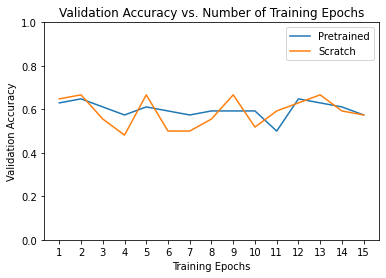

In [ ]:
# Initialize the non-pretrained version of the model used for this run
scratch_model,_ = initialize_model(model_name, num_classes, feature_extract=False, use_pretrained=False)
scratch_model = scratch_model.to(device)
scratch_optimizer = optim.SGD(scratch_model.parameters(), lr=0.001, momentum=0.9)
scratch_criterion = nn.CrossEntropyLoss()
_,scratch_hist = train_model(scratch_model, dataloaders_dict, scratch_criterion, scratch_optimizer, num_epochs=num_epochs, is_inception=(model_name=="inception"))

# Plot the training curves of validation accuracy vs. number 
#  of training epochs for the transfer learning method and
#  the model trained from scratch
ohist = []
shist = []

ohist = [h.cpu().numpy() for h in hist]
shist = [h.cpu().numpy() for h in scratch_hist]

plt.title("Validation Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Validation Accuracy")
plt.plot(range(1,num_epochs+1),ohist,label="Pretrained")
plt.plot(range(1,num_epochs+1),shist,label="Scratch")
plt.ylim((0,1.))
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.show()

In [ ]:
#save model_ft
OUTPUT_DIR_image_notsogood = "/content/drive/MyDrive/NNDL/"
MODEL_FILE_NAME_image_notsogood = "image_model_notsogood.bin"

model_to_save = scratch_model
output_model_file = os.path.join(OUTPUT_DIR_image_notsogood, MODEL_FILE_NAME_image_notsogood)
torch.save(model_to_save.state_dict(), output_model_file)

# BERT

Text mode subnet.

In this case we use the pretrained BERT model, as it gives a high accuracy without any further optimization.

In [ ]:
from sklearn.model_selection import train_test_split

texts = df_final.Report
labels = df_final.Normal
rest_texts, test_texts, rest_labels, test_labels = train_test_split(texts, labels, test_size=0.1, random_state=1)
train_texts, dev_texts, train_labels, dev_labels = train_test_split(rest_texts, rest_labels, test_size=0.1, random_state=1)

print("Train size:", len(train_texts))
print("Dev size:", len(dev_texts))
print("Test size:", len(test_texts))

Train size: 31631
Dev size: 3515
Test size: 3906


In [ ]:
target_names = list(set(labels))
label2idx = {label: idx for idx, label in enumerate(target_names)}
print(label2idx)

{False: 0, True: 1}


In [ ]:
#lior only run this
!pip install -q --user torch==1.4.0 -f https://download.pytorch.org/whl/cu101/torch_stable.html
!pip install transformers==4.11.3.

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.9 MB 32.9 MB/s 
     |████████████████████████████████| 3.3 MB 58.7 MB/s 
  Using cached huggingface_hub-0.11.1-py3-none-any.whl (182 kB)
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.9.3
    Uninstalling tokenizers-0.9.3:
      Successfully uninstalled tokenizers-0.9.3
  Attempting uninstall: transformers
    Found existing installation: transformers 3.5.0
    Uninstalling transformers-3.5.0:
      Successfully uninstalled transformers-3.5.0


In [ ]:
!pip uninstall transformers
!pip install transformers==3.5

Found existing installation: transformers 4.25.1
Uninstalling transformers-4.25.1:
  Would remove:
    /usr/local/bin/transformers-cli
    /usr/local/lib/python3.8/dist-packages/transformers-4.25.1.dist-info/*
    /usr/local/lib/python3.8/dist-packages/transformers/*
Proceed (y/n)? y
  Successfully uninstalled transformers-4.25.1
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.3 MB 31.4 MB/s 
     |████████████████████████████████| 880 kB 97.1 MB/s 
     |████████████████████████████████| 1.1 MB 65.8 MB/s 
     |████████████████████████████████| 2.9 MB 94.3 MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895260 sha256=233b04adf5df16fa097cf640a9ae0f0a491397e9df2c0b4a3668bad8aba43a32
  Stored in directory: /root/.cache/pip/wheels/82/ab/9b/c15899bf659ba74f623ac776e861cf2eb8608c1825ddec66a4
Successfully built sacremoses
  Attempting uninstall: tokenizers
    F

In [ ]:
BERT_MODEL = "bert-base-uncased"

from transformers.tokenization_bert import BertTokenizer
from transformers.modeling_bert import BertForSequenceClassification

tokenizer = BertTokenizer.from_pretrained(BERT_MODEL)

model = BertForSequenceClassification.from_pretrained(BERT_MODEL, num_labels = len(label2idx))
device = torch.device("cuda")
model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [ ]:
import logging
import numpy as np

logging.basicConfig(format = '%(asctime)s - %(levelname)s - %(name)s -   %(message)s',
                    datefmt = '%m/%d/%Y %H:%M:%S',
                    level = logging.INFO)
logger = logging.getLogger(__name__)

MAX_SEQ_LENGTH=100

class BertInputItem(object):
    """An item with all the necessary attributes for finetuning BERT."""

    def __init__(self, text, input_ids, input_mask, segment_ids, label_id):
        self.text = text
        self.input_ids = input_ids
        self.input_mask = input_mask
        self.segment_ids = segment_ids
        self.label_id = label_id
        

def convert_examples_to_inputs(example_texts, example_labels, label2idx, max_seq_length, tokenizer, verbose=0):
    """Loads a data file into a list of `InputBatch`s."""
    
    input_items = []
    examples = zip(example_texts, example_labels)
    for (ex_index, (text, label)) in enumerate(examples):

        # Create a list of token ids
        input_ids = tokenizer.encode(f"[CLS] {text} [SEP]")
        if len(input_ids) > max_seq_length:
            input_ids = input_ids[:max_seq_length]

        # All our tokens are in the first input segment (id 0).
        segment_ids = [0] * len(input_ids)

        # The mask has 1 for real tokens and 0 for padding tokens. Only real
        # tokens are attended to.
        input_mask = [1] * len(input_ids)

        # Zero-pad up to the sequence length.
        padding = [0] * (max_seq_length - len(input_ids))
        input_ids += padding
        input_mask += padding
        segment_ids += padding

        assert len(input_ids) == max_seq_length
        assert len(input_mask) == max_seq_length
        assert len(segment_ids) == max_seq_length

        label_id = label2idx[label]

        input_items.append(
            BertInputItem(text=text,
                          input_ids=input_ids,
                          input_mask=input_mask,
                          segment_ids=segment_ids,
                          label_id=label_id))

        
    return input_items

train_features = convert_examples_to_inputs(train_texts, train_labels, label2idx, MAX_SEQ_LENGTH, tokenizer, verbose=0)
dev_features = convert_examples_to_inputs(dev_texts, dev_labels, label2idx, MAX_SEQ_LENGTH, tokenizer)
test_features = convert_examples_to_inputs(test_texts, test_labels, label2idx, MAX_SEQ_LENGTH, tokenizer)


In [ ]:
import logging
import numpy as np

from torch.utils.data import TensorDataset, DataLoader, SequentialSampler

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, SequentialSampler

def get_data_loader(features, max_seq_length, batch_size, shuffle=True): 

    all_input_ids = torch.tensor([f.input_ids for f in features], dtype=torch.long)
    all_input_mask = torch.tensor([f.input_mask for f in features], dtype=torch.long)
    all_segment_ids = torch.tensor([f.segment_ids for f in features], dtype=torch.long)
    all_label_ids = torch.tensor([f.label_id for f in features], dtype=torch.long)
    data = TensorDataset(all_input_ids, all_input_mask, all_segment_ids, all_label_ids)

    dataloader = DataLoader(data, shuffle=shuffle, batch_size=batch_size)
    return dataloader

BATCH_SIZE = 16

train_dataloader = get_data_loader(train_features, MAX_SEQ_LENGTH, BATCH_SIZE, shuffle=True)
dev_dataloader = get_data_loader(dev_features, MAX_SEQ_LENGTH, BATCH_SIZE, shuffle=False)
test_dataloader = get_data_loader(test_features, MAX_SEQ_LENGTH, BATCH_SIZE, shuffle=False)
   

In [ ]:
def evaluate(model, dataloader):
    model.eval()
    
    eval_loss = 0
    nb_eval_steps = 0
    predicted_labels, correct_labels = [], []

    for step, batch in enumerate(tqdm(dataloader, desc="Evaluation iteration")):
        batch = tuple(t.to(device) for t in batch)
        input_ids, input_mask, segment_ids, label_ids = batch

        with torch.no_grad():
            tmp_eval_loss, logits = model(input_ids, attention_mask=input_mask,
                                          token_type_ids=segment_ids, labels=label_ids)

        outputs = np.argmax(logits.to('cpu'), axis=1)
        label_ids = label_ids.to('cpu').numpy()
        
        predicted_labels += list(outputs)
        correct_labels += list(label_ids)
        
        eval_loss += tmp_eval_loss.mean().item()
        nb_eval_steps += 1

    eval_loss = eval_loss / nb_eval_steps
    
    correct_labels = np.array(correct_labels)
    predicted_labels = np.array(predicted_labels)
        
    return eval_loss, correct_labels, predicted_labels


In [ ]:
!pip install transformers==4.11.3.
!pip install torch==1.5.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached transformers-4.11.3-py3-none-any.whl (2.9 MB)
  Using cached tokenizers-0.10.3-cp38-cp38-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_12_x86_64.manylinux2010_x86_64.whl (3.3 MB)
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.9.3
    Uninstalling tokenizers-0.9.3:
      Successfully uninstalled tokenizers-0.9.3
  Attempting uninstall: transformers
    Found existing installation: transformers 3.5.0
    Uninstalling transformers-3.5.0:
      Successfully uninstalled transformers-3.5.0


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 752.0 MB 6.8 kB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.4.0
    Uninstalling torch-1.4.0:
      Successfully uninstalled torch-1.4.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.14.0+cu116 requires torch==1.13.0, but you have torch 1.5.0 which is incompatible.
torchtext 0.14.0 requires torch==1.13.0, but you have torch 1.5.0 which is incompatible.
torchaudio 0.13.0+cu116 requires torch==1.13.0, but you have torch 1.5.0 which is incompatible.
fastai 2.7.10 requires torch<1.14,>=1.7, but you have torch 1.5.0 which is incompatible.


In [ ]:
from transformers import get_linear_schedule_with_warmup
from transformers.optimization import AdamW
from transformers import get_linear_schedule_with_warmup

GRADIENT_ACCUMULATION_STEPS = 1
NUM_TRAIN_EPOCHS = 20
LEARNING_RATE = 5e-5
WARMUP_PROPORTION = 0.1
MAX_GRAD_NORM = 5

num_train_steps = int(len(train_dataloader.dataset) / BATCH_SIZE / GRADIENT_ACCUMULATION_STEPS * NUM_TRAIN_EPOCHS)
num_warmup_steps = int(WARMUP_PROPORTION * num_train_steps)

param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
    ]

optimizer = AdamW(optimizer_grouped_parameters, lr=LEARNING_RATE, correct_bias=False)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=num_train_steps)


In [ ]:
import torch
import os
from tqdm import trange
from tqdm import tqdm_notebook as tqdm
from sklearn.metrics import classification_report, precision_recall_fscore_support

OUTPUT_DIR = "/content/drive/MyDrive/NNDL/"
MODEL_FILE_NAME = "pytorch_model1.bin"
MODEL_FILE_NAME2 = "pytorch_model2.bin"
PATIENCE = 2

loss_history = []
no_improvement = 0
for _ in trange(int(NUM_TRAIN_EPOCHS), desc="Epoch"):
    model.train()
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0
    for step, batch in enumerate(tqdm(train_dataloader, desc="Training iteration")):
        batch = tuple(t.to(device) for t in batch)
        input_ids, input_mask, segment_ids, label_ids = batch

        outputs = model(input_ids, attention_mask=input_mask, token_type_ids=segment_ids, labels=label_ids)
        loss = outputs[0]

        if GRADIENT_ACCUMULATION_STEPS > 1:
            loss = loss / GRADIENT_ACCUMULATION_STEPS

        loss.backward()
        tr_loss += loss.item()

        if (step + 1) % GRADIENT_ACCUMULATION_STEPS == 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), MAX_GRAD_NORM)  
            
            optimizer.step()
            optimizer.zero_grad()
            scheduler.step()
            
    dev_loss, _, _ = evaluate(model, dev_dataloader)
    
    print("Loss history:", loss_history)
    print("Dev loss:", dev_loss)
    
    if len(loss_history) == 0 or dev_loss < min(loss_history):
        no_improvement = 0
        model_to_save = model.module if hasattr(model, 'module') else model
        output_model_file = os.path.join(OUTPUT_DIR, MODEL_FILE_NAME)
        torch.save(model_to_save.state_dict(), output_model_file)
    else:
        no_improvement += 1
    
    if no_improvement >= PATIENCE: 
        print("No improvement on development set. Finish training.")
        model_to_save = model.module if hasattr(model, 'module') else model
        output_model_file = os.path.join(OUTPUT_DIR, MODEL_FILE_NAME2)
        torch.save(model_to_save.state_dict(), output_model_file)
        break
    
    loss_history.append(dev_loss)

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]<ipython-input-19-66b3d047ea16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for step, batch in enumerate(tqdm(train_dataloader, desc="Training iteration")):


Training iteration:   0%|          | 0/1977 [00:00<?, ?it/s]

<ipython-input-15-4bd3a7527c41>:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for step, batch in enumerate(tqdm(dataloader, desc="Evaluation iteration")):


Evaluation iteration:   0%|          | 0/220 [00:00<?, ?it/s]

Loss history: []
Dev loss: 0.028960320963894694


Epoch:   5%|▌         | 1/20 [10:11<3:13:44, 611.82s/it]

Training iteration:   0%|          | 0/1977 [00:00<?, ?it/s]

Evaluation iteration:   0%|          | 0/220 [00:00<?, ?it/s]

Epoch:  10%|█         | 2/20 [20:27<3:04:14, 614.14s/it]

Loss history: [0.028960320963894694]
Dev loss: 0.04062222749952608


Training iteration:   0%|          | 0/1977 [00:00<?, ?it/s]

Evaluation iteration:   0%|          | 0/220 [00:00<?, ?it/s]

Loss history: [0.028960320963894694, 0.04062222749952608]
Dev loss: 0.10687345510496843
No improvement on development set. Finish training.


Epoch:  10%|█         | 2/20 [30:43<4:36:32, 921.83s/it]


In [ ]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Sun_Feb_14_21:12:58_PST_2021
Cuda compilation tools, release 11.2, V11.2.152
Build cuda_11.2.r11.2/compiler.29618528_0


In [ ]:
model_state_dict = torch.load(os.path.join(OUTPUT_DIR, MODEL_FILE_NAME), map_location=lambda storage, loc: storage)
model_bert = BertForSequenceClassification.from_pretrained(BERT_MODEL, state_dict=model_state_dict, num_labels = len(target_names))
model_bert.to(device)

model_bert.eval()

_, train_correct, train_predicted = evaluate(model_bert, train_dataloader)

print("Training performance:", precision_recall_fscore_support(train_correct, train_predicted, average="micro"))

bert_accuracy = np.mean(train_correct == train_predicted)


<ipython-input-15-4bd3a7527c41>:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for step, batch in enumerate(tqdm(dataloader, desc="Evaluation iteration")):


Evaluation iteration:   0%|          | 0/1977 [00:00<?, ?it/s]

Training performance: (0.9957004204735861, 0.9957004204735861, 0.9957004204735861, None)


# attempt bert evaluation on df_final_test dataframe, which contains the final test data

In [ ]:
from sklearn.model_selection import train_test_split

texts = df_final_test.Report
labels = df_final_test.Normal
rest_texts, test_texts, rest_labels, test_labels = train_test_split(texts, labels, test_size=0.1, random_state=1)
train_texts, dev_texts, train_labels, dev_labels = train_test_split(rest_texts, rest_labels, test_size=0.1, random_state=1)

print("Train size:", len(train_texts))
print("Dev size:", len(dev_texts))
print("Test size:", len(test_texts))

Train size: 18
Dev size: 3
Test size: 3


In [ ]:
target_names = list(set(labels))
label2idx = {label: idx for idx, label in enumerate(target_names)}
print(label2idx)

{False: 0, True: 1}


In [ ]:
BERT_MODEL = "bert-base-uncased"

from transformers.tokenization_bert import BertTokenizer
from transformers.modeling_bert import BertForSequenceClassification

tokenizer = BertTokenizer.from_pretrained(BERT_MODEL)

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

In [ ]:
import logging
import numpy as np

logging.basicConfig(format = '%(asctime)s - %(levelname)s - %(name)s -   %(message)s',
                    datefmt = '%m/%d/%Y %H:%M:%S',
                    level = logging.INFO)
logger = logging.getLogger(__name__)

MAX_SEQ_LENGTH=100

class BertInputItem(object):
    """An item with all the necessary attributes for finetuning BERT."""

    def __init__(self, text, input_ids, input_mask, segment_ids, label_id):
        self.text = text
        self.input_ids = input_ids
        self.input_mask = input_mask
        self.segment_ids = segment_ids
        self.label_id = label_id
        

def convert_examples_to_inputs(example_texts, example_labels, label2idx, max_seq_length, tokenizer, verbose=0):
    """Loads a data file into a list of `InputBatch`s."""
    
    input_items = []
    examples = zip(example_texts, example_labels)
    for (ex_index, (text, label)) in enumerate(examples):

        # Create a list of token ids
        input_ids = tokenizer.encode(f"[CLS] {text} [SEP]")
        if len(input_ids) > max_seq_length:
            input_ids = input_ids[:max_seq_length]

        # All our tokens are in the first input segment (id 0).
        segment_ids = [0] * len(input_ids)

        # The mask has 1 for real tokens and 0 for padding tokens. Only real
        # tokens are attended to.
        input_mask = [1] * len(input_ids)

        # Zero-pad up to the sequence length.
        padding = [0] * (max_seq_length - len(input_ids))
        input_ids += padding
        input_mask += padding
        segment_ids += padding

        assert len(input_ids) == max_seq_length
        assert len(input_mask) == max_seq_length
        assert len(segment_ids) == max_seq_length

        label_id = label2idx[label]

        input_items.append(
            BertInputItem(text=text,
                          input_ids=input_ids,
                          input_mask=input_mask,
                          segment_ids=segment_ids,
                          label_id=label_id))

        
    return input_items

train_features = convert_examples_to_inputs(train_texts, train_labels, label2idx, MAX_SEQ_LENGTH, tokenizer, verbose=0)
dev_features = convert_examples_to_inputs(dev_texts, dev_labels, label2idx, MAX_SEQ_LENGTH, tokenizer)
test_features = convert_examples_to_inputs(test_texts, test_labels, label2idx, MAX_SEQ_LENGTH, tokenizer)




In [ ]:
total_features = convert_examples_to_inputs(texts, labels, label2idx, MAX_SEQ_LENGTH, tokenizer, verbose=0) 

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, SequentialSampler

def get_data_loader(features, max_seq_length, batch_size, shuffle=True): 

    all_input_ids = torch.tensor([f.input_ids for f in features], dtype=torch.long)
    all_input_mask = torch.tensor([f.input_mask for f in features], dtype=torch.long)
    all_segment_ids = torch.tensor([f.segment_ids for f in features], dtype=torch.long)
    all_label_ids = torch.tensor([f.label_id for f in features], dtype=torch.long)
    data = TensorDataset(all_input_ids, all_input_mask, all_segment_ids, all_label_ids)

    dataloader = DataLoader(data, shuffle=shuffle, batch_size=batch_size)
    return dataloader

BATCH_SIZE = 16

train_dataloader = get_data_loader(train_features, MAX_SEQ_LENGTH, BATCH_SIZE, shuffle=True)
dev_dataloader = get_data_loader(dev_features, MAX_SEQ_LENGTH, BATCH_SIZE, shuffle=False)
test_dataloader = get_data_loader(test_features, MAX_SEQ_LENGTH, BATCH_SIZE, shuffle=False)
   

In [ ]:
total_dataloader = get_data_loader(total_features, MAX_SEQ_LENGTH, BATCH_SIZE, shuffle=False)

In [ ]:
def evaluate(model, dataloader):
    model.eval()
    
    eval_loss = 0
    nb_eval_steps = 0
    predicted_labels, correct_labels = [], []

    for step, batch in enumerate(tqdm(dataloader, desc="Evaluation iteration")):
        batch = tuple(t.to(device) for t in batch)
        input_ids, input_mask, segment_ids, label_ids = batch

        with torch.no_grad():
            tmp_eval_loss, logits = model(input_ids, attention_mask=input_mask,
                                          token_type_ids=segment_ids, labels=label_ids)

        outputs = np.argmax(logits.to('cpu'), axis=1)
        label_ids = label_ids.to('cpu').numpy()
        
        predicted_labels += list(outputs)
        correct_labels += list(label_ids)
        
        eval_loss += tmp_eval_loss.mean().item()
        nb_eval_steps += 1

    eval_loss = eval_loss / nb_eval_steps
    
    correct_labels = np.array(correct_labels)
    predicted_labels = np.array(predicted_labels)
        
    return eval_loss, correct_labels, predicted_labels


In [ ]:
OUTPUT_DIR = "/content/drive/MyDrive/NNDL/"
MODEL_FILE_NAME = "pytorch_model2.bin"

model_state_dict = torch.load(os.path.join(OUTPUT_DIR, MODEL_FILE_NAME), map_location=lambda storage, loc: storage)
model_bert = BertForSequenceClassification.from_pretrained(BERT_MODEL, state_dict=model_state_dict, num_labels = 2)
model_bert.to(device)

model_bert.eval()

_, train_correct, train_predicted = evaluate(model_bert, total_dataloader)

print("Training performance:", precision_recall_fscore_support(train_correct, train_predicted, average="micro"))

bert_accuracy = np.mean(train_correct == train_predicted)

<ipython-input-171-4bd3a7527c41>:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for step, batch in enumerate(tqdm(dataloader, desc="Evaluation iteration")):


Evaluation iteration:   0%|          | 0/2 [00:00<?, ?it/s]

Training performance: (1.0, 1.0, 1.0, None)


In [ ]:
print (train_correct)

[1 0 0 0 0 1 0 1 1 0 0 0 0 0 0 1 0 1 0 0 1 1 1 0]


citations: 

https://github.com/nlptown/nlp-notebooks/blob/master/Text%20classification%20with%20BERT%20in%20PyTorch.ipynb

https://github.com/auriml/Rx-thorax-automatic-captioning/blob/master/image_prediction/Predict_Pleural_Effusion.ipynb



# Weighted average

In [ ]:
#df_final_test

In [ ]:
df_final_test.head()

,ImageID,labels,Report,Normal
0,216840111366964012819207061112010316094555679_...,[normal],estudi dentr limit normal .,True
1,216840111366964012373310883942009181081546904_...,"[aortic elongation, COPD signs]",elongacion aortic . sign radiolog epoc .,False
2,126397712012687540784611673197697059691_fp0cu9...,[unchanged],sin hallazg radiolog signific . sin cambi con...,False
3,216840111366964013307756408102012093111819763_...,[costophrenic angle blunting],pinzamient sen costofren derech .,False
4,216840111366964012558082906712010004133151165_...,"[laminar atelectasis, supra aortic elongation,...",mejori radiolog con resolucion infiltr bilate...,False


In [ ]:
texts = df_final_test.Report
labels = df_final_test.Normal
rest_texts, test_texts, rest_labels, test_labels = train_test_split(texts, labels, test_size=0.1, random_state=1)
train_texts, dev_texts, train_labels, dev_labels = train_test_split(rest_texts, rest_labels, test_size=0.1, random_state=1)

print("Train size:", len(train_texts))
print("Dev size:", len(dev_texts))
print("Test size:", len(test_texts))

Train size: 18
Dev size: 3
Test size: 3


In [ ]:
temp = df_merged.loc[df_merged['ImageID']== filename]
tmp = temp['Report'].item()
tmp

' . . . . cardiomegali . pinzamient ambos sen costofren sugest component derram pleural asoci . hili prominent probabl orig vascul . respect estudi previ fech 29 04 2016 con comp apreci infiltr alveol lsd nuev aparicion context pacient sugier orig cardiogen redistribucion aunqu sin pod descart orig inflamatori infecci fiebr leucocitosis correlacion con dat clinic .'

In [ ]:
def liors_get_data_loader(features, max_seq_length, batch_size, shuffle=True): 

    all_input_ids = torch.tensor([f.input_ids for f in features], dtype=torch.long)
    all_input_mask = torch.tensor([f.input_mask for f in features], dtype=torch.long)
    all_segment_ids = torch.tensor([f.segment_ids for f in features], dtype=torch.long)
    all_label_ids = torch.tensor([f.label_id for f in features], dtype=torch.long)

    
    data = TensorDataset(all_input_ids, all_input_mask, all_segment_ids, all_label_ids)

    dataloader = DataLoader(data, shuffle=shuffle, batch_size=batch_size)
    return dataloader

BATCH_SIZE = 16

train_dataloader = liors_get_data_loader(train_features, MAX_SEQ_LENGTH, BATCH_SIZE, shuffle=True)
dev_dataloader = liors_get_data_loader(dev_features, MAX_SEQ_LENGTH, BATCH_SIZE, shuffle=False)
test_dataloader = liors_get_data_loader(test_features, MAX_SEQ_LENGTH, BATCH_SIZE, shuffle=False)
   

In [ ]:
def combine_model_outputs(model_img, model_text, dataloader, num_epochs=2):
  predicted_labels, correct_labels = [], []
  for epoch in range(num_epochs):
      print('Epoch {}/{}'.format(epoch, num_epochs - 1))
      print('-' * 10)
      running_corrects = 0

      # Iterate over data.
      for input_img, input_text, label in dataloader:
          input_img = input_img.to(device)

          with torch.no_grad():
            outputs_img = model_img(input_img.unsqueeze(0))
            _, pred_img = torch.max(outputs_img, 1)

            segment_ids = [0] * len(input_text)
            input_mask = [1] * len(input_ids)
            tmp_eval_loss, logits = model_text(input_text, attention_mask=input_mask,
                                        token_type_ids=segment_ids, labels=label)

            pred_text = np.argmax(logits.to('cpu'), axis=1)

            pred = 0.5*pred_img + 0.5*pred_text

            predicted_labels += list(pred)
            correct_labels += list(label)

      correct_labels = np.array(correct_labels)
      predicted_labels = np.array(predicted_labels)

      print(f'Model accuracy : {np.mean(predicted_labels == correct_labels)}')

  return correct_labels, predicted_labels

In [ ]:
combine_model_outputs(image_model_temp, model_bert, test_dataloader, num_epochs=1)

In [ ]:
_, train_correct, train_predicted = evaluate(model_bert, total_dataloader)

print("Training performance:", precision_recall_fscore_support(train_correct, train_predicted, average="micro"))

bert_accuracy = np.mean(train_correct == train_predicted)

In [ ]:
#this is output of bert for all models 
len(train_predicted)
train_predicted

#this is the correct for bert
len(train_correct)



24

In [ ]:
def combine_model_outputs(model_img, model_text, dataloader, num_epochs=2, berts_preds):
  predicted_labels, correct_labels = [], []
  for epoch in range(num_epochs):
      print('Epoch {}/{}'.format(epoch, num_epochs - 1))
      print('-' * 10)
      running_corrects = 0

      # Iterate over data.
      for input_img, input_text, label in dataloader:
          input_img = input_img.to(device)

          with torch.no_grad():
            outputs_img = model_img(input_img.unsqueeze(0))
            _, pred_img = torch.max(outputs_img, 1)

            segment_ids = [0] * len(input_text)
            input_mask = [1] * len(input_ids)
            tmp_eval_loss, logits = model_text(input_text, attention_mask=input_mask,
                                        token_type_ids=segment_ids, labels=label)

            pred_text = np.argmax(logits.to('cpu'), axis=1)

            pred = 0.5*pred_img + 0.5*pred_text

            predicted_labels += list(pred)
            correct_labels += list(label)

      correct_labels = np.array(correct_labels)
      predicted_labels = np.array(predicted_labels)

      print(f'Model accuracy : {np.mean(predicted_labels == correct_labels)}')

  return correct_labels, predicted_labels

In [ ]:
combine_model_outputs_lior(model_ft, model_bert, test_dataloader, num_epochs=2, train_predicted)

In [ ]:
def combine_model_outputs_lior(model, dataloaders, criterion, optimizer, num_epochs=1, is_inception=False):
    since = time.time()

    val_acc_history = []
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['test']:
            if phase == 'trn':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            #here is where I will do model averaging...
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'trn'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'trn':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)
                    

                    pred = 0.5*outputs + 0.5*pred_text

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'trn':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))


        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False